In [134]:
%pylab inline

from xgboost.sklearn import XGBClassifier
from typing import Tuple
import xgboost as xgb
import pandas as pd
import json
import matplotlib.pyplot as plt
import sklearn

dataset = pd.read_csv('290T-mrt-lab2/data/multisession-eeg.csv')
fromstring = lambda array_str: np.fromstring(array_str, dtype=float, sep=',')
dataset.raw_fft = dataset.raw_fft.apply(fromstring)
# dataset.raw_fft.iloc[0]

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fromstring', 'clf', 'negative', 'positive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Passthoughts

What if you could simply *think your password*? That's the premise behind *passthoughts*. We'll discuss passthoughts in more depth in lecture 3, but for now, we'll lay this out as a classification problem:

> Given a reading, and a person, is that person who they claim to be?

We'll structure this problem as follows: For each subject, we'll train a classifier. That subject's readings will be positive example, and everyone else's readings will be negative examples.

We can make this a little fancier by having people use specific thoughts (e.g. "focus on your breathing," "sing a song in your head," etc). We'll make sure our methods can handle this case, but for the time being, we'll just use the `"unabeled"` readings - people doing nothing in particular.

We'll use subject `A` as our "target" individual. We will train on this subject for this assignment, and train against the other subjects in the corpus (subjects `B` and `C`).

In [90]:
def to_matrix (series):
    return np.array([ x for x in series ])

def readings_right_subject_right_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_any_task (subj):
    return to_matrix(dataset[
        (dataset['subject'] != subj)
    ].raw_fft)

In [92]:
positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = readings_wrong_subj_any_task('A')
positive.shape, negative.shape

((40, 516), (1228, 516))

## TODO

Notice how we structured our positive and negative examples:

- *Positive examples*: The right person thinking the right task.

- *Negative examples*: The wrong person thinking any task (whether it is right or wrong).

In the context of passthoughts, consider other possibilites for selecting positive and negative features. Here, (1) pick one configuration of positive and negative examples, aside from the ones listed, and (2) discuss their possible consequences (pros/cons). Explain how you might evaluate this selection (with data, with user experiments, etc - your choice).

The other possible positive examples could be:
1. Right subject, any task (this is the scenario where we are validating the person itself by the inherence factor and not taking into account the knowledge factor)
2. Any subject, right task (if we want to validate the right thought - this could be a scenario where in multiple people can authenticate using the same passthought if they have the knowledge factor). Ofcourse, depending on our usecase, this could be bucketed into a negative example too.

The other negative examples could be:
1. Right subject, Wrong task (We want to validate on knowledge and inherence factor)
2. Wrong subject, Wrong task (This would be a subset of Wrong Subject, Any task - however, would be interesting to compare the performance of our trained model if this metric is used)
3. Any Subject, Wrong task (when you want to be able to authenticate multiple users as long as they "know" the secret thought)
For illustration, I would choose the combination of the following positive and negative examples in different configurations:

Config 1 (Authentication by inherence, ignoring knowledge factor): 
    Positive:

        Right subject, any task

    Negative:

        Wrong subject, any task

Config 2 (Authenticate any user as long as they know the secret): 
    Positive:

        Any subject, right task

    Negative:

        Any subject, wrong task

Config 3 (Conventional- one person authentication based on inherence and knowledge factor): 
    Positive:

        Right subject, right task

    Negative:

        Wrong subject, any task
        Right subject, wrong task
        
The working and evaluation of each configuration is shown at the end of the lab so that the existing setup is not modified.

Now, we'll turn these data into our feature/label matrices `X` and `y`.

In [78]:
X = np.concatenate([positive, negative])
X

array([[ 10.31130409,  14.77069664,  12.21351433, ..., -17.47436905,
        -10.13802242,  -9.64999294],
       [ 11.21512699,  14.95685577,  10.83694172, ..., -18.60851669,
        -13.82363701, -12.32877541],
       [  6.34600163,  12.59247112,  10.84169102, ..., -21.45312691,
        -19.91650391, -21.89144516],
       ..., 
       [ 36.44969559,  38.1983223 ,  35.0042305 , ...,  15.73941231,
         14.61825275,  13.56678772],
       [ 34.59482574,  38.99107742,  47.8829689 , ...,   0.48166957,
         -4.53305626,  -8.9541769 ],
       [ 27.57326889,  25.42376328,  39.77492142, ...,   1.50189328,
          3.34984589,   0.97760612]])

In [79]:
y = np.array([ 0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]

Note that we are assigning `0` to "positive" examples, and `1` to "negative" examples. That means `0` will mean "ACCEPT" and `1` will mean "REJECT."

## TODO

Now, train and test a classifier! Estimate your classifier's accuracy.

In [80]:
# Your code here....

def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [81]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [82]:
clf.score(X_validate, y_validate)

0.98329355608591884

For authentication, what we want even more than "accuracy" here are two metrics:

- False Acceptance Rate (FAR): The percentage of readings *not* from subject A incorrectly classified "ACCEPT."
- False Rejection Rate (FRR): The percentage of readings *from* subject A incorrectly classified 'REJECT."

For authentication /security/, we want FAR to be as low as possible (so nobody can break in).
For authentication /usability/, we want FRR to be low (so user's don't get frustrated constantly re-trying their passthought).

In [83]:
def far_frr (classifier, features, labels):
    # predict all the labels
    y_pred = classifier.predict(features)
    false_accepts = 0
    false_rejects = 0
    for predicted, actual in zip(y_pred, labels):
        # if we should have rejected,
        # but in fact accepted,
        if (actual == 1) and (predicted == 0):
            # increment false accepts
            false_accepts += 1
        # if we should have accepted,
        # but in fact rejected,
        if (actual == 0) and (predicted == 1):
            # increment false rejections
            false_rejects += 1
    # calculate proportions for each
    far = false_accepts / len(list(filter(lambda x: x==0, y_pred)))
    frr = false_rejects / len(list(filter(lambda x: x==1, y_pred)))
    return far, frr

In [84]:
far, frr = far_frr(clf, X_validate, y_validate)
f'FAR: {far} - FRR: {frr}'

'FAR: 0.3 - FRR: 0.009779951100244499'

Now, these results might be good. 

But our classifier's accuracy could be misleading.   

Can you see why? 

Few reasons why this number could be misleading are:

1. The dataset for positive case (40) is way smaller than the negative set (1228). So, the representation could be skewed.

2. Also, the above case does not consider the use case of right person doing the wrong task. So, this value might not be an accurate measurement going by inherence + knowledge factor approach.

# Nonstationarity

We are training, and testing, using data recorded over a single session. As we know, EEG changes over time, a property known as *nonstationarity*. Will our great results still hold a few weeks later?

Let's take subject `A`'s data from sessions 1 and 2, which were recorded a few weeks after session 0.

In [60]:
X_subja_sess1 = readings_right_subject_right_task('A', 'unlabeled', 1)
X_subja_sess2 = readings_right_subject_right_task('A', 'unlabeled', 2)
X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])
y_subja_later = [ 0 for x in X_subja_later ]

Now, let's try the classifier we trained on the original data, testing it on the later data.

In [61]:
far, frr = far_frr(clf, X_subja_later, y_subja_later)
f'FAR: {far*100}% - FRR: {frr*100}%'

'FAR: 0.0% - FRR: 100.0%'

As we will discuss more in lecture 3, this is a problem for us. After all, we can calibrate our target subject, but we then expect them to leave the lab and go use the device later on. If their state changes so much that they can no longer be authenticated, we can't very well claim our system is accurate!

## TODO

The crux of the lab focuses on nonstationarity. At minimum, your mission is to quantify and qualify *what* is changing in EEG signals over time. You may use any tools in answering this question.

You also have your choice of corpus:

- Study subject `A`'s recordings over the three sessions provided here.
- Study one subject's recordings over the course of a year.

You can use both of these corpora, if you would like.

Some questions to spur investigation:

- What features of readings cause a classifier that works on earlier recordings fail on later ones?
- What features remain the same? Are there any?
- What might be the source of these changing features? Changing placement in the EEG device? Changing properties of the brain?

Please note below all work you do, and any notes you make along the way. Ideally, your work should read like a story - words (and questions!) interspersed with code. Good luck, and have fun!

In [66]:
# This is the working of the first task which requires us to evaluate multiple positive and negative examples and configurations

# Helper functions for different configurations
def to_matrix (series):
    return np.array([ x for x in series ])

def readings_right_subject_right_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subject_any_task (subj, session=0):
    return to_matrix(dataset[
        (dataset['subject'] != subj) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_right_subject_any_task (subj, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_right_subject_wrong_task (subj, right_task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] != right_task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subject_wrong_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] != subj) &
        (dataset['label'] != task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_any_subject_wrong_task (task, session=0):
    return to_matrix(dataset[
        (dataset['label'] != task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_any_subject_right_task (task, session=0):
    return to_matrix(dataset[
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

In [68]:
# Config 1 (Authentication by inherence, ignoring knowledge factor): 
#     Positive:

#         Right subject, any task

#     Negative:

#         Wrong subject, any task


positive = readings_right_subject_any_task('A', 0)
negative = readings_wrong_subject_any_task('A', 0)
positive.shape, negative.shape

X = np.concatenate([positive, negative])
X
y = np.array([ 0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)
clf.score(X_validate, y_validate)
far, frr = far_frr(clf, X_validate, y_validate)
f'CONFIG1: FAR: {far} - FRR: {frr}'


'CONFIG1: FAR: 0.0 - FRR: 0.007177033492822967'

In [72]:
# Config 2 (Authenticate any user as long as they know the secret): 
#     Positive:

#         Any subject, right task

#     Negative:

#         Any subject, wrong task

positive = readings_any_subject_right_task('unlabeled', 0)
negative = readings_any_subject_wrong_task('unlabeled', 0)
positive.shape, negative.shape

X = np.concatenate([positive, negative])
X
y = np.array([ 0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)
clf.score(X_validate, y_validate)
far, frr = far_frr(clf, X_validate, y_validate)
f'CONFIG2: FAR: {far} - FRR: {frr}'

'CONFIG2: FAR: 0.23376623376623376 - FRR: 0.15384615384615385'

In [71]:
# Config 3 (Conventional- one person authentication based on inherence and knowledge factor): 
#     Positive:

#         Right subject, right task

#     Negative:

#         Wrong subject, any task
#         Right subject, wrong task

positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = readings_wrong_subject_any_task('A', 0)
negative2 = readings_right_subject_wrong_task('A', 'unlabeled', 0)
positive.shape, negative.shape

X = np.concatenate([positive, negative, negative2])
X
y = np.array([ 0 for x in positive] + [ 1 for x in negative] + [ 1 for x in negative2])
assert X.shape[0] == y.shape[0]
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)
clf.score(X_validate, y_validate)
far, frr = far_frr(clf, X_validate, y_validate)
f'CONFIG3: FAR: {far} - FRR: {frr}'

'CONFIG3: FAR: 1.0 - FRR: 0.014644351464435146'

In [196]:
#Config 1 (using only inherence factor) gives an excellent acceptance rate and does not accept a wrong person while Config(3) using both inherence and knowledge factor gives a bad FAR of 1! This could be due to overwhelming number of negative scenarios.
#Config 1 also gives a pretty low FRR compared to the other two Configs.

In [197]:
# Non stationarity
# I am attempting to get readings of A across 3 sessions for different activties to compare the difference in FAR and FRR in each case
# and check how much are the rates affected in each activity
positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = readings_wrong_subject_any_task('A', 0)
negative2 = readings_right_subject_wrong_task('A', 'unlabeled', 0)
positive.shape, negative.shape

X = np.concatenate([positive, negative, negative2])
X
y = np.array([ 0 for x in positive] + [ 1 for x in negative] + [ 1 for x in negative2])
assert X.shape[0] == y.shape[0]
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)
clf.score(X_validate, y_validate)
far, frr = far_frr(clf, X_validate, y_validate)
f'CONFIG3: FAR: {far} - FRR: {frr}'

X_subja_sess1 = readings_right_subject_right_task('A', 'unlabeled', 1)
X_subja_sess2 = readings_right_subject_right_task('A', 'unlabeled', 2)
X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])
y_subja_later = [ 0 for x in X_subja_later ]
far, frr = far_frr(clf, X_subja_later, y_subja_later)
f'(Test data for unlabeled) SESSION1 FAR: {far*100}% - FRR: {frr*100}%'


'(Test data for unlabeled) SESSION1 FAR: 0.0% - FRR: 100.0%'

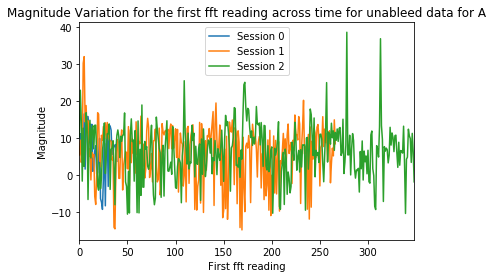

In [188]:
# Non stationarity
# I am attempting to get readings of A across 3 sessions for different activties to compare the difference in the first fft reading with time
a_0 = readings_right_subject_right_task('A', 'unlabeled', 0)[:,0]
a_1 = readings_right_subject_right_task('A', 'unlabeled', 1)[:,0]
a_2 = readings_right_subject_right_task('A', 'unlabeled', 2)[:,0]

a_0, a_1


y_0 = [ 0 for x in a_0 ]
y_1 = [ 1 for x in a_1 ]
y_2 = [ 2 for x in a_2 ]

ax = pd.Series(a_0).plot(label='Session 0')

ax = pd.Series(a_1).plot(ax =ax, label='Session 1')

ax = pd.Series(a_2).plot(ax =ax, label='Session 2')
ax.legend()
plt.title('Magnitude Variation for the first fft reading across time for unableed data for A')
plt.xlabel('First fft reading')
plt.ylabel('Magnitude')

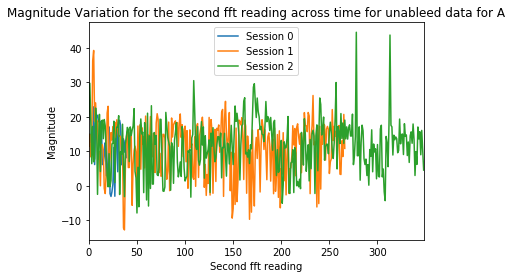

In [189]:
a_3 = readings_right_subject_right_task('A', 'unlabeled', 0)[:,1]
a_4 = readings_right_subject_right_task('A', 'unlabeled', 1)[:,1]
a_5 = readings_right_subject_right_task('A', 'unlabeled', 2)[:,1]

a_0, a_1


axx = pd.Series(a_3).plot(label='Session 0')

axx = pd.Series(a_4).plot(ax =axx, label='Session 1')

axx = pd.Series(a_5).plot(ax =axx, label='Session 2')
axx.legend()
plt.title('Magnitude Variation for the second fft reading across time for unableed data for A')
plt.xlabel('Second fft reading')
plt.ylabel('Magnitude')
##RESEARCH
# It was interesting to note how brain waves do follow a dynamic system that lies under the time series we observe in a normal 
# scenario, based on the following research: 
#     "Recent advances in surrogate time series and non-linear analysis showed that neurophysiological signals such 
#     as EEG or MEG cannot be fully described by studying their linear properties only. 
#     A key assumption in non-linear analysis of EEG/MEG is that there exists a dynamic system underlying the observed 
#     time series. From the theoretical point of view, the neural ensembles can be represented by single oscillators. 
#     Further, different neural ensembles can be coupled with long-range connections, forming a large-scale network of 
#     coupled oscillators. Encouraging results were obtained in modeling the resting state network dynamics wherein the 
#     realistic fluctuations in brain signals are considered a result of coupled non-linear systems, in general, 
#     with time delays in coupling." (SOURCE:Vasily A. Vakorin. Exploring Age-Related Changes in Dynamical 
#     Non-Stationarity in Electroencephalographic Signals during Early Adolescence)

In [108]:
## RESEARCH

## The study below emphasises how eeg signals change with age and also sleep cycles!
    "Several studies show that sleep EEG power also declines across adolescence. 
    One cross-sectional study comparing the sleep EEG of prepubertal (ages 9.6 to 12.9) and 
    mature adolescents (ages 11.8 to 15.9 years) found that more mature participants had less EEG power across a 
    wide range of frequencies. This effect was statistically significant at frequencies below 7 Hz for both 
    REM and NREM sleep, in the sigma (11.8–12.6 Hz) and beta (16.2 – 16.8 Hz) bands for NREM, and at all 
    frequencies below 15 Hz except for the alpha range (8.6 – 9.4 Hz) for REM sleep" 
    (Source: Leila Tarokh. Developmental Changes in the Human Sleep EEG During Early Adolescence)

IndentationError: unexpected indent (<ipython-input-108-25c4d0d2610f>, line 4)

In [151]:
dataset1 = pd.read_csv('../../longitudinal-packaged/labeled/0.csv')
dataset2 = pd.read_csv('../../longitudinal-packaged/labeled/1.csv')
dataset3 = pd.read_csv('../../longitudinal-packaged/labeled/2.csv')
dataset4 = pd.read_csv('../../longitudinal-packaged/labeled/3.csv')
dataset5 = pd.read_csv('../../longitudinal-packaged/labeled/4.csv')

dataset1['event name'].unique()

array(['blinkInstruction', 'blink1', 'blink2', 'blink3', 'blink4',
       'blink5', 'relaxInstruction', 'relax', 'mathInstruction', 'math1',
       'math2', 'math3', 'math4', 'math5', 'math6', 'math7', 'math8',
       'math9', 'math10', 'math11', 'math12', 'musicInstruction', 'music',
       'videoInstruction', 'video-ver2', 'thinkOfItemsInstruction-ver2',
       'thinkOfItems-ver2', 'colorInstruction1', 'colorInstruction2',
       'readyRound1', 'colorRound1-1', 'colorRound1-2', 'colorRound1-3',
       'colorRound1-4', 'colorRound1-5', 'colorRound1-6', 'readyRound2',
       'colorRound2-1', 'colorRound2-2', 'colorRound2-3', 'colorRound2-4',
       'colorRound2-5', 'colorRound2-6', 'readyRound3', 'colorRound3-1',
       'colorRound3-2', 'colorRound3-3', 'colorRound3-4', 'colorRound3-5',
       'colorRound3-6', 'readyRound4', 'colorRound4-1', 'colorRound4-2',
       'colorRound4-3', 'colorRound4-4', 'colorRound4-5', 'colorRound4-6',
       'readyRound5', 'colorRound5-1', 'colorRound5-2'

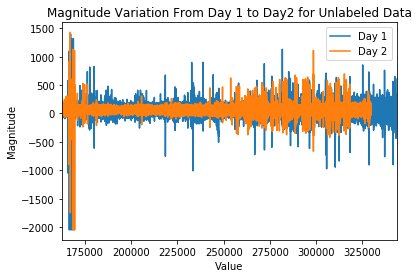

In [191]:
unlabeledDataDay1 =dataset1[dataset1['event name'] == 'unlabeled']
ax = pd.Series(unlabeledDataDay1[' Value']).plot(label='Day 1')
unlabeledDataDay2 =dataset2[dataset2['event name'] == 'unlabeled']
pd.Series(unlabeledDataDay2[' Value']).plot(ax =ax, label='Day 2')
ax.legend()
plt.title('Magnitude Variation From Day 1 to Day2 for Unlabeled Data')

plt.xlabel('Value')
plt.ylabel('Magnitude')

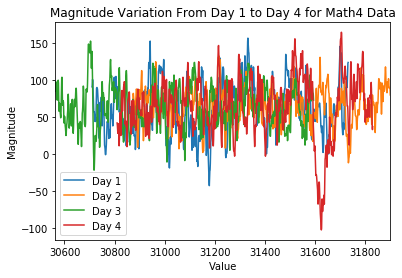

In [193]:
unlabeledDataDay1 =dataset1[dataset1['event name'] == 'math4']
ax = pd.Series(unlabeledDataDay1[' Value']).plot(label='Day 1')
unlabeledDataDay2 =dataset2[dataset2['event name'] == 'math4']
pd.Series(unlabeledDataDay2[' Value']).plot(ax =ax, label='Day 2')
unlabeledDataDay3 =dataset3[dataset3['event name'] == 'math4']
pd.Series(unlabeledDataDay3[' Value']).plot(ax =ax, label='Day 3')
unlabeledDataDay4 =dataset4[dataset4['event name'] == 'math4']
pd.Series(unlabeledDataDay4[' Value']).plot(ax =ax, label='Day 4')
ax.legend()
plt.title('Magnitude Variation From Day 1 to Day 4 for Math4 Data')
plt.xlabel('Value')
plt.ylabel('Magnitude')

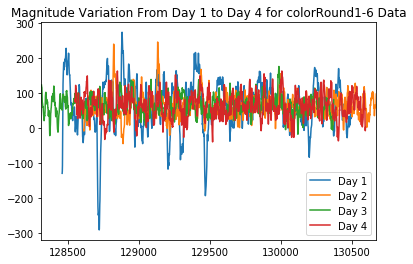

In [194]:
unlabeledDataDay1 =dataset1[dataset1['event name'] == 'colorRound1-6']
ax = pd.Series(unlabeledDataDay1[' Value']).plot(label='Day 1')
unlabeledDataDay2 =dataset2[dataset2['event name'] == 'colorRound1-6']
pd.Series(unlabeledDataDay2[' Value']).plot(ax =ax,label='Day 2')
unlabeledDataDay3 =dataset3[dataset3['event name'] == 'colorRound1-6']
pd.Series(unlabeledDataDay3[' Value']).plot(ax =ax, label='Day 3')
unlabeledDataDay4 =dataset4[dataset4['event name'] == 'colorRound1-6']
pd.Series(unlabeledDataDay4[' Value']).plot(ax =ax, label='Day 4')
ax.legend()
plt.title('Magnitude Variation From Day 1 to Day 4 for colorRound1-6 Data')

In [ ]:
##Observation
#There is a slight shift in magnitudes as we go from one day to another
# The following could be potential reasons behind non stationarity: 
#1. A shift in position of device (assuming sources of waves are from different parts of the brain) could a possible reason for the shift
#2. External environment could be another in which case some new freq maybe dominant in the readings
#3. Another reasons could be related to monotonity of repeating the same excercise and hence, not getting the same accurate waves
#4. Sleep cycle as well as moods could also affect the change in magnitudes
#5. Based on the above research cited above, there exists a dynamic system underlying the observed 
#time series. From the theoretical point of view, the neural ensembles can be represented by single oscillators. 